In [18]:
import warnings
warnings.filterwarnings("ignore")  #忽略告警
# 数学库
import math
import numpy as np
import pandas as pd

# 读写数据
import pandas as pd
import os
import csv

# 训练进度条
from tqdm import tqdm
import matplotlib.pyplot as plt

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

In [19]:
!nvidia-smi

Tue Apr 12 15:54:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.14       Driver Version: 430.14       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   63C    P0   131W / 149W |  11200MiB / 11441MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   33C    P0    73W / 149W |    439MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [6]:
# 参数解释及选择
# criterion:    可以选用：nn.L1Loss, nn.SmoothL1Loss, nn.MSELoss, nn.CrossEntropyLoss, nn.NLLLoss
# optimizer:    torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) 
            #   torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 
# seed:         随机种子
# select_all:   Whether to use all features.
# test_ratio:   test_size = train_size * test_ratio
# valid_ratio:  validation_size = train_size * valid_ratio
# n_epochs:     Number of epochs. 
# batch_size:
# learning_rate:
# early_stop:   # If model has not improved for this many consecutive epochs, stop training.     
# save_path:    
# window_size:  # 滑动窗口大小

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.MSELoss(reduction='mean')
config = {
    'criterion':None,
    'optimizer':None,
    'seed': 5201314,  
    'select_all': True,  
    'test_ratio':0.2,    
    'valid_ratio': 0.2,   
    'n_epochs': 10000,   
    'batch_size': 16, 
    'learning_rate': 0.01, 
    'early_stop': 1000, 
    'save_path': './models/model.ckpt',
    'save_path_hidden': './models/rnn_hidden.ckpt',
    'window_size':3
}

In [42]:
class My_Model(nn.Module):
    def __init__(self, input_size, hidden_size=8, output_size=1, num_layers=2):
        super(My_Model, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.reg = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #x.shape (batch, seq, feature)
        x, _ = self.rnn(x) 
        #x.shape (batch, seq, hidden)
        b, s, h = x.shape  #(batch, seq, hidden)
        #x = x.view(b,s * h) #转化为线性层的输入方式
        #print(x.shape)
        x = x[:,s-1,:]
        x = x.reshape(b, h)
        
        x = self.reg(x)
        x = x.squeeze(1)
#        print(x.shape)
        return x


class LSTM(nn.Module):
    def __init__(self, input_size, window_size, hidden_size=5, output_size=1, num_layers=2):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.reg = nn.Linear(hidden_size * window_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)  #x.shape (batch, seq, feature)
        b, s, h = x.shape   #x.shape (batch, seq, hidden)        
        x = x.reshape(b, s*h)
        x = self.reg(x)
        x = x.squeeze(1)
        return x

class LSTM_FULL(nn.Module):
    def __init__(self, input_size, window_size, hidden_size=5, output_size=1, num_layers=2):
        super(LSTM_FULL, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.reg = nn.Linear(hidden_size * window_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x) #x.shape (batch, seq, feature)        
        b, s, h = x.shape  #x.shape (batch, seq, hidden)
        x = x.reshape(b, s*h)
        x = self.reg(x)
        x = x.squeeze(1)
        return x
    
class FC(nn.Module):
    def __init__(self,feature_size,window_size):
        super(FC, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(feature_size*window_size, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = x.flatten(1)
        x = self.layer1(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [43]:
class My_Model():   #将模型和配置记录下来，将描述也记录下来，打包起来记成一个类
    def __init__(self, model, toTrain=True, config1={}, description=''):
        self.config = config1
        #print(self.config)
        self.model = model
        self.toTrain = toTrain
        self.description = description
    def toString():
        print(self.model)
        
class trainer():
    def __init__(self, feature_size, config={}):
        self.config = config
        self.feature_size = feature_size
        self.models = []
        self.saveMatric = []
        self.cnt = 0
        pass
    
    '''
        每个my_model有四个参数，
        model：模型本身，
        toTrain：训练与否，
        config：该模型相关的参数，若为空，则default
    '''
    
    # 这里是直接append一个类方法，所以还需要自己生成
    def append(self, Model,toTrain = True, config1={}, description=''):
        config2 = {}
        if not('save_path' in config1):
            config2['save_path'] = f'./models/model{self.cnt}.ckpt'
            config3 = config1.copy()
            config3.update(config2)
        tmpConfig = config.copy()
        tmpConfig.update(config3)
        network = Model(self.feature_size, tmpConfig['window_size']).to(device)
        tmpModel = My_Model(network, toTrain=toTrain, config1=tmpConfig, description=description)
        
        self.cnt = self.cnt + 1
        self.saveMatric.append(tmpModel.toTrain)
        self.models.append(tmpModel)
        pass
    
    def run(self, train_loader, valid_loader, device):
        for myModel in self.models:
            if myModel.toTrain:
                self.__train__(train_loader, valid_loader, myModel.model, myModel.config, device)
                
    def draw_all(self):
        for myModel in self.models:
            self.__draw__(f_cnt = self.feature_size, model=myModel.model, config=myModel.config,description=myModel.description)
    
    def save(self):
        for myModel in self.models:
            torch.save(myModel.model.state_dict(), myModel.config['save_path']) # Save your best model
            
    def load(self):
        for myModel in self.models:
            #print(myModel.config['save_path'])
            myModel.model.load_state_dict(torch.load(myModel.config['save_path']))
            
    def __draw__(self,f_cnt, model ,config ,TrainingSet = True,ValidSet = True, TestingSet = True ,description=''):
        #print(config)
        data = prep_data('./flights.csv')
        end = data.shape[1]
        train_data, test_data = train_valid_split(data, config['test_ratio'], config['seed'])
        train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])
        x_train, x_valid, x_test, y_train, y_valid, y_test = select_feat(train_data, valid_data, test_data, config['select_all'])

        a = x_valid.copy()
        b = y_valid.copy()
        x_train = np.vstack([x_train,a])
        y_train = np.hstack([y_train,b])
        window_size = config['window_size']
        train_dataset,valid_dataset, test_dataset = LSTMDataset(x_train,config['window_size'], y_train), \
                                      LSTMDataset(x_valid,config['window_size'], y_valid),\
                                      LSTMDataset(x_test,config['window_size'], y_test)
        # Pytorch data loader loads pytorch dataset into batches.
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)
        valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)
        valid_set_size = int(config['valid_ratio'] * len(train_dataset) // config['batch_size'] * config['batch_size']) 
        train_data_length = len(train_dataset) - valid_set_size
        

        fig = plt.figure(figsize=(20,3))
        fig.suptitle(description)
        plt.subplots_adjust(top=0.8)
        
        down = 0.025
        if TrainingSet == True:
            # 绘制训练集
            plt.subplot(1,3,1)
            cnt = 0
            for i in train_loader:
                cnt = cnt + 1
            #print(cnt)
            preds,loss = predict(train_loader, model, device)
            preds = preds.reshape(-1)
            y = y_train[window_size-1:]
            plt.plot(preds,label='predict')
            plt.plot(y,label='target')
            minn = min(preds.min(),y.min())
            plt.text(0,minn-down,'Valid loss:{:.6f}'.format(loss))
            plt.axvline(train_data_length)
            plt.legend(loc='upper left')
            plt.title("Trainning") # 图形标题
            #print('Train+Valid loss:{:.6f}'.format(loss))

        if ValidSet == True:
            plt.subplot(1,3,2)
            cnt = 0
            for i in valid_loader:
                cnt = cnt + 1
            #print(cnt)
            preds,loss = predict(valid_loader, model, device)
            y = valid_data[window_size-1:,end-1:end].flatten()
            minn = min(preds.min(),y.min())
            plt.text(0,minn - down,'Valid loss:{:.6f}'.format(loss))
            plt.plot(preds,label='predict')
            plt.plot(y,label='target')
            plt.legend(loc='upper left')
            plt.title("Valid") # 图形标题
            #print('Valid loss:{:.6f}'.format(loss))

        if TestingSet == True:
            # 绘制测试集
            plt.subplot(1,3,3)
            preds, loss = predict(test_loader, model, device)
            y = test_data[window_size-1:,end-1:end].flatten()
            minn = min(preds.min(),y.min())
            plt.text(0,minn - down,'Valid loss:{:.6f}'.format(loss))
            plt.plot(preds,label='predict')
            plt.plot(y,label='target')
            plt.legend(loc='upper left')
            plt.title("Testing") # 图形标题
            #print('Testing loss:{:.6f}'.format(loss))
            pass
        plt.show()
            
        
    def __train__(self,train_loader, valid_loader, model, config, device):

        # 这里用了随机梯度下降，想改成Adam。但还没改。
        if config['criterion'] == 'L1':
            criterion = nn.L1Loss(reduction='mean')
        elif config['criterion'] == 'SmoothL1':
            criterion = nn.SmoothL1Loss(reduction='mean')
        elif config['criterion'] == 'CrossEntropy':
            criterion = nn.CrossEntropyLoss(reduction='mean')
        elif config['criterion'] == 'NLL':
            criterion = nn.NLLLoss(reduction='mean')
        else: #默认是MSE
            criterion = nn.MSELoss(reduction='mean')
        
        if config['optimizer'] == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 
        else:
            #默认是SGD 随机梯度下降
            optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) 

        if not os.path.isdir('./models'):
            os.mkdir('./models') # Create directory of saving models.

        n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            pbar.set_description(str(model.__class__.__name__).ljust(12,' ')+"Valid loss: %.6f" %best_loss)
            model.train() # Set your model to train mode.
            loss_record = []
            for x, y in train_loader:
                optimizer.zero_grad()               # Set gradient to zero.
                x, y = x.to(device), y.to(device)   # Move your data to device. 
                pred = model(x)
                loss = criterion(pred, y)
                loss.backward()                     # Compute gradient(backpropagation).
                optimizer.step()                    # Update parameters.
                step += 1
                loss_record.append(loss.detach().item())

            mean_train_loss = sum(loss_record)/len(loss_record)

            model.eval() # Set your model to evaluation mode.
            loss_record = []
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                with torch.no_grad():
                    #pred, _ = model(x, h_state)
                    pred = model(x)
                    loss = criterion(pred, y)
                loss_record.append(loss.item())

            mean_valid_loss = sum(loss_record)/len(loss_record)

            #print(f'Epoch [{epoch+1}/{n_epochs}]','train_loss {:.6f}, valid_loss {:.6f}..., best_loss {:.6f}'.format(mean_train_loss, mean_valid_loss, best_loss))
            #print(mean_train_loss,mean_valid_loss)
            #print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
            #writer.add_scalar('Loss/valid', mean_valid_loss, step)
            #print(mean_valid_loss,best_loss)
            if mean_valid_loss < best_loss:
                best_loss = mean_valid_loss
                torch.save(model.state_dict(), config['save_path']) # Save your best model
                #draw(x_train.shape[1])
                #print(f'Epoch [{epoch+1}/{n_epochs}]','Saving model with train loss {:.6f}, valid loss {:.6f}...'.format(mean_train_loss,best_loss))
                early_stop_count = 0
            else: 
                early_stop_count += 1

            if early_stop_count >= config['early_stop']:
                #print('\nModel is not improving, so we halt the training session.')
                return

    def print(self):
        for i in self.models:
            print(i.model)
            print(i.description)
            print()
    

In [44]:
def same_seed(seed): 
    '''设置随机种子'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''将数据集划分为训练集、验证集、测试集'''
    valid_set_size = int(valid_ratio * len(data_set) // config['batch_size'] * config['batch_size']) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = data_set[:train_set_size], data_set[train_set_size:]
    #train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)


def dense_to_onehot(a):
    '''将某一列转换为独热码矩阵返回回去。'''
    import collections
    Dict=collections.Counter(a)
    cnt = 0
    for i in Dict:
        Dict[i] = cnt
        cnt = cnt + 1
    labels_onehot = np.zeros((len(a),len(Dict)))
    for i in range(len(a)):
        id = Dict[a[i]]
        labels_onehot[i][id] = 1
        #print(type(labels_onehot[i][id]))
    #print(labels_onehot)
    return labels_onehot

def predict(test_loader, model, device):
    '''预测模型，返回结果'''
    model.eval() # Set your model to evaluation mode.
    preds = []
    loss_record = []
    
    for x in test_loader:
        #print(x)
        x, y = x
        x = x.to(device)
        y = y.to(device)
            
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())
            loss = criterion(pred, y)
            loss_record.append(loss.detach().item())
            
    mean_train_loss = sum(loss_record)/len(loss_record)
    preds = torch.cat(preds, dim=0).numpy()
    return preds, mean_train_loss

def select_feat(train_data, valid_data, test_data, select_all=True):
    '''选择有用的特征'''
    y_train, y_valid, y_test = train_data[:,-1], valid_data[:,-1] , test_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data[:,:-1]

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns.
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid, y_test


In [45]:
def prep_data(path):
    '''读取CSV，并进行独热码等初步处理'''
    Dict = {'January':1, 
    'February':2,
    'March':3,
    'April':4,
    'May':5,
    'June':6,
    'July':7,
    'August':8,
    'September':9,
    'October':10,
    'November':11,
    'December':12}
        
    df = pd.read_csv('flights.csv')
    df['month'] = df['month'].map(Dict)
    
    for i in df.columns:
        df[i] = (df[i] - df[i].min()) / (df[i].max()-df[i].min())
    
    l = config['batch_size'] - len(df)%config['batch_size']
    f_cnt = df.shape[1]
    if l % config['batch_size']!=0:
        df_zeros = pd.DataFrame(data=np.zeros((l,f_cnt)),columns=df.columns)
        df = df.append(df_zeros)

    return df.values
#print(prep_data('flights.csv'))

In [46]:
class LSTMDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, window_size, y=None):
        self.window_size = window_size
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        '''滑动窗口，每次返回window_size行的数据'''
        feature_cnt = self.x.shape[1]
        tmpx = self.x[idx]
        for i in range(self.window_size-1):
            if idx+i+1 <= len(self.x)-self.window_size:
                tmpx = torch.cat((tmpx,self.x[idx+i+1]),0)
            else:
                zeros = torch.zeros((feature_cnt))
                tmpx = torch.cat((tmpx,zeros),0)
        tmpx = tmpx.reshape(self.window_size,-1)
        if self.y is None:
            # do prediction.
            return tmpx
        else:
            if idx <= len(self.x) - self.window_size:
                return tmpx, self.y[idx+self.window_size-1]
            else:
                return tmpx, torch.tensor(0)

    def __len__(self):
        return len(self.x)


In [47]:
# 随机种子初始化
same_seed(config['seed'])

# 读取数据
data = prep_data('./flights.csv')
print(data.shape)

train_data, test_data = train_valid_split(data, config['test_ratio'], config['seed'])
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

print(train_data.shape,valid_data.shape)

# 查看输出
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")

print()
# 选择特征
x_train, x_valid, x_test, y_train, y_valid, y_test = select_feat(train_data, valid_data, test_data, config['select_all'])


print(f'number of features: {x_train.shape[1]}')

# 初始化DataSet
train_dataset, valid_dataset, test_dataset = LSTMDataset(x_train,config['window_size'], y_train), \
                                            LSTMDataset(x_valid,config['window_size'], y_valid), \
                                            LSTMDataset(x_test,config['window_size'])
print(len(train_dataset) / config['batch_size'])
print(len(valid_dataset) / config['batch_size'])
print(len(test_dataset) / config['batch_size'])
# 用Pytorch自带的DataLoader进行数据加载。注意这里加了个drop_last=True.意思是把最后一个不组batch_size大小的batch，去掉，方便训练。
# 在小训练集可能会增大误差，但在超大数据集可以忽略。
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)
# for x,y in train_loader:
#     print(x.shape)

(144, 3)
(112, 3) (16, 3)
train_data size: (112, 3) 
valid_data size: (16, 3) 
test_data size: (16, 3)

number of features: 2
7.0
1.0
1.0


In [48]:
Trainer = trainer(feature_size=x_train.shape[1])

feature_size = x_train.shape[1]
window_size = config['window_size']

configtmp = { 
    'criterion':'MSE',
    'optimizer':'Adam',
    'learning_rate': 0.01
}

Trainer.append(LSTM ,config1=configtmp, description='LSTM')
Trainer.append(LSTM_FULL ,config1=configtmp, description='LSTM_FULL')
Trainer.append(FC ,config1=configtmp, description='Fully Connected Network')

Trainer.run(train_loader, valid_loader,device)


FC          Valid loss: 0.054797:  11%|█         | 1053/10000 [01:07<09:36, 15.52it/s]


In [ ]:
Trainer.save()

In [15]:
Trainer.load()

In [16]:
    print(Trainer.__class__.__name__)

trainer


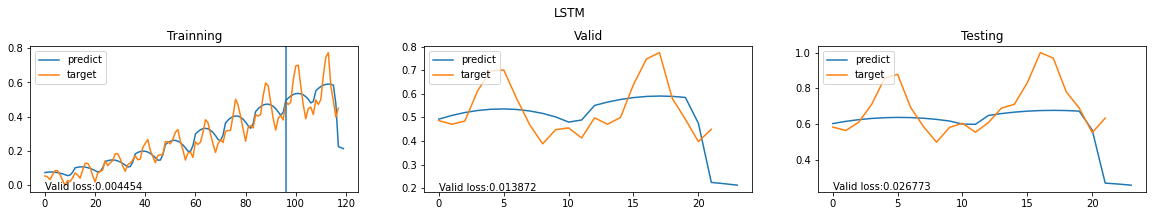

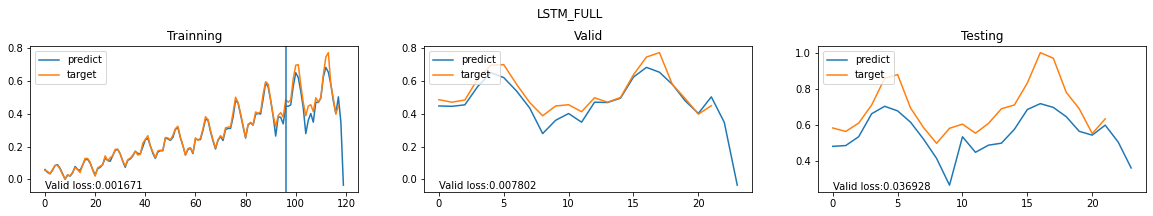

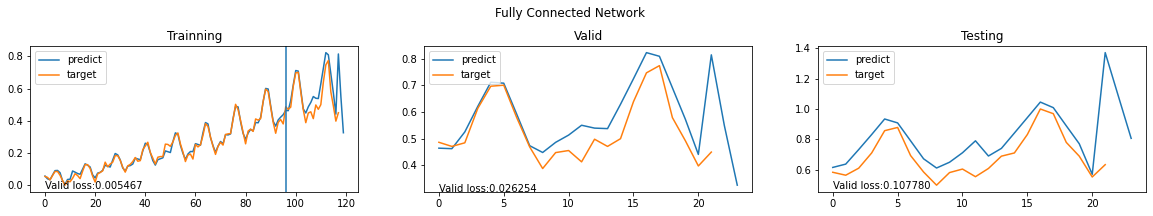

In [25]:
Trainer.draw_all()

555 {'criterion': 'MSE', 'optimizer': 'Adam', 'learning_rate': 0.01}
666666666
0
{'criterion': 'MSE', 'optimizer': 'Adam', 'seed': 5201314, 'select_all': True, 'test_ratio': 0.2, 'valid_ratio': 0.2, 'n_epochs': 10000, 'batch_size': 8, 'learning_rate': 0.01, 'early_stop': 1000, 'save_path': './models/model0.ckpt', 'save_path_hidden': './models/rnn_hidden.ckpt', 'window_size': 3}
{'criterion': 'MSE', 'optimizer': 'Adam', 'learning_rate': 0.01}
555 {'criterion': 'MSE', 'optimizer': 'Adam', 'learning_rate': 0.01}
666666666
1
{'criterion': 'MSE', 'optimizer': 'Adam', 'seed': 5201314, 'select_all': True, 'test_ratio': 0.2, 'valid_ratio': 0.2, 'n_epochs': 10000, 'batch_size': 8, 'learning_rate': 0.01, 'early_stop': 1000, 'save_path': './models/model1.ckpt', 'save_path_hidden': './models/rnn_hidden.ckpt', 'window_size': 3}
{'criterion': 'MSE', 'optimizer': 'Adam', 'learning_rate': 0.01}
555 {'criterion': 'MSE', 'optimizer': 'Adam', 'learning_rate': 0.01}
666666666
2
{'criterion': 'MSE', 'optim

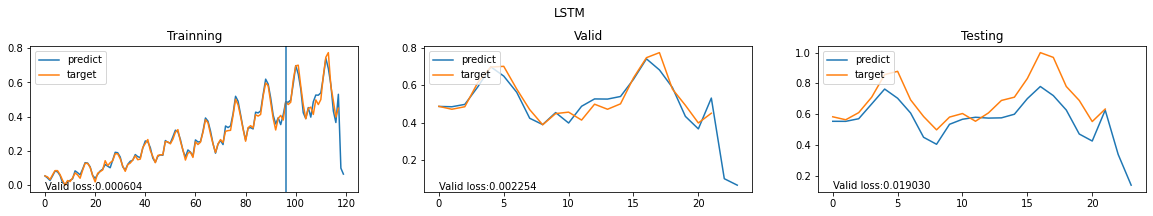

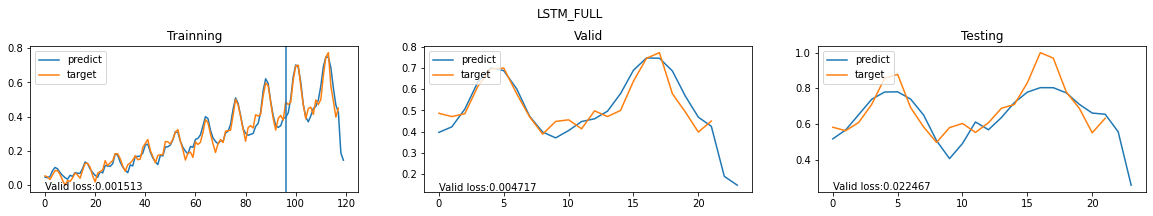

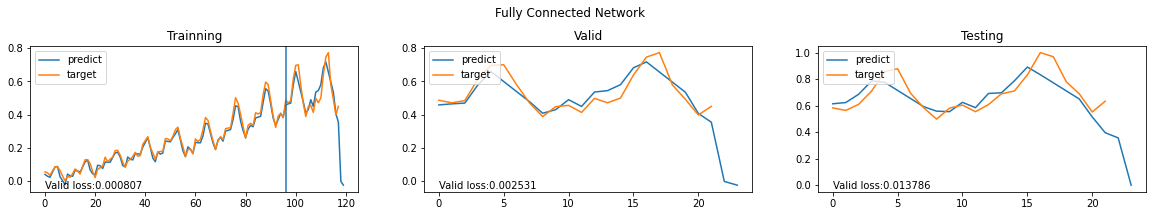

In [139]:
Trainer = trainer(feature_size=x_train.shape[1])
My_Model.cnt = 0 #
feature_size = x_train.shape[1]
window_size = config['window_size']

configtmp = { 
    'criterion':'MSE',
    'optimizer':'Adam',
    'learning_rate': 0.01
}
Trainer.append(LSTM ,config1=configtmp, description='LSTM')
Trainer.append(LSTM_FULL ,config1=configtmp, description='LSTM_FULL')
Trainer.append(FC ,config1=configtmp, description='Fully Connected Network')
Trainer.load()
Trainer.draw_all()

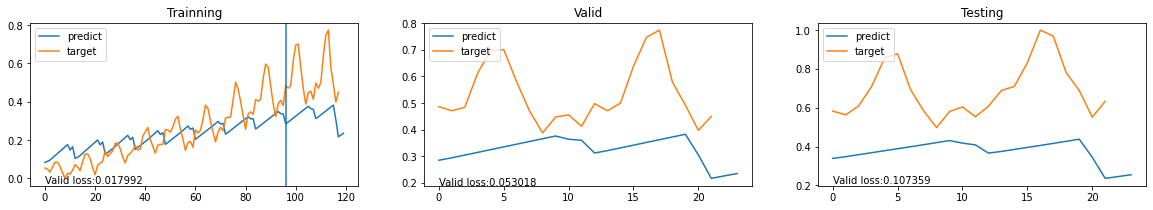

Epoch [1/10000] Saving model with train loss 0.053019, valid loss 0.053018...


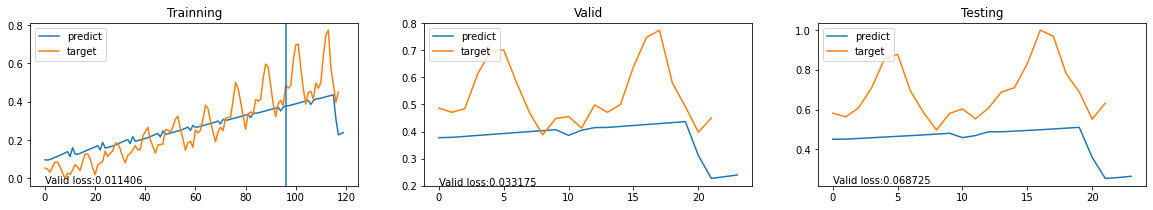

Epoch [2/10000] Saving model with train loss 0.010935, valid loss 0.033175...


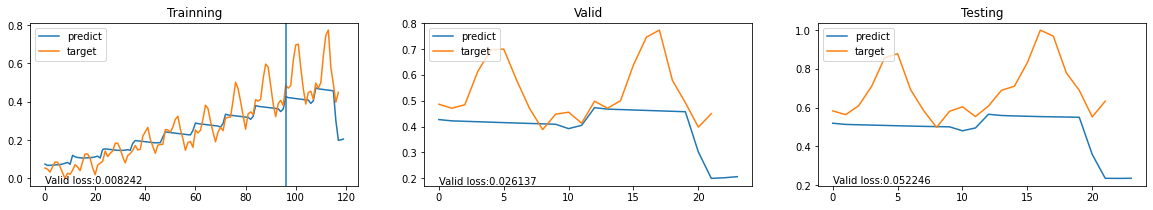

Epoch [3/10000] Saving model with train loss 0.007091, valid loss 0.026137...


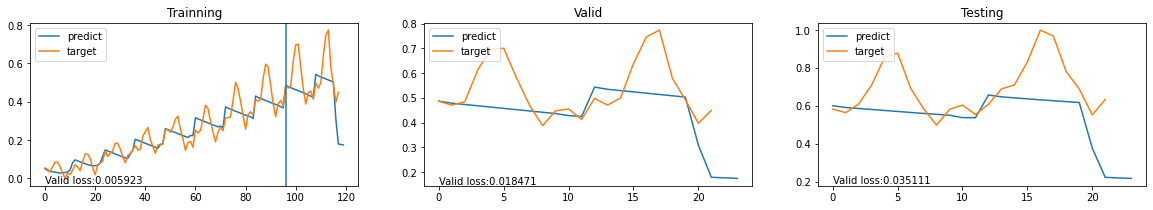

Epoch [4/10000] Saving model with train loss 0.004674, valid loss 0.018471...


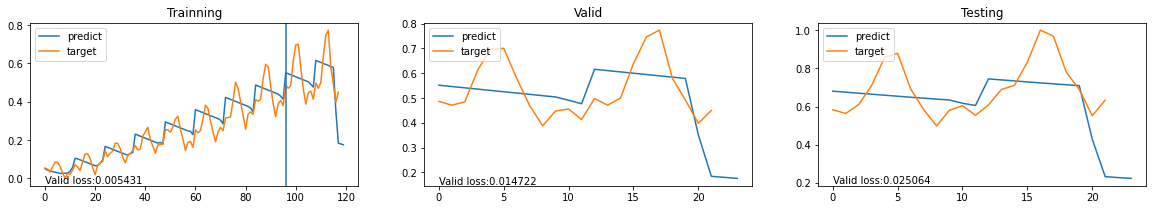

Epoch [5/10000] Saving model with train loss 0.004504, valid loss 0.014722...


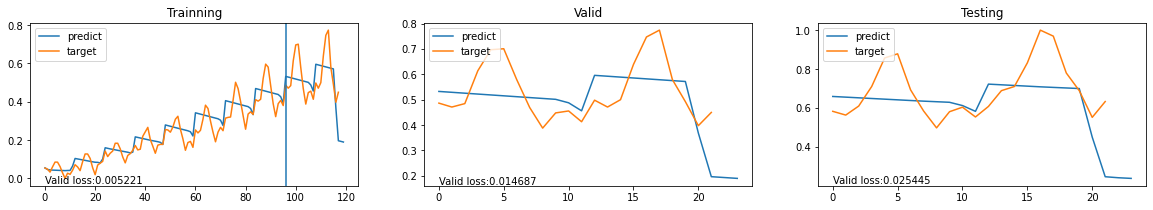

Epoch [14/10000] Saving model with train loss 0.004477, valid loss 0.014687...


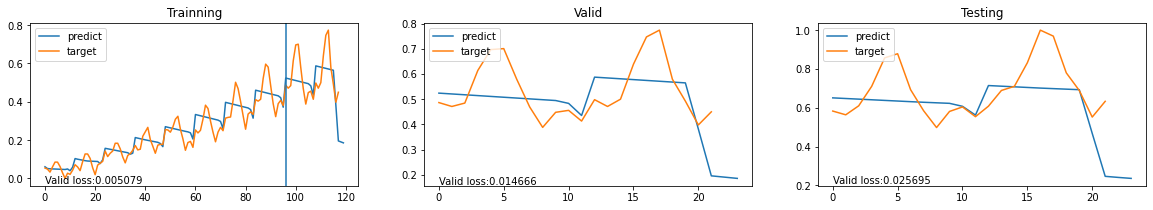

Epoch [26/10000] Saving model with train loss 0.004161, valid loss 0.014666...


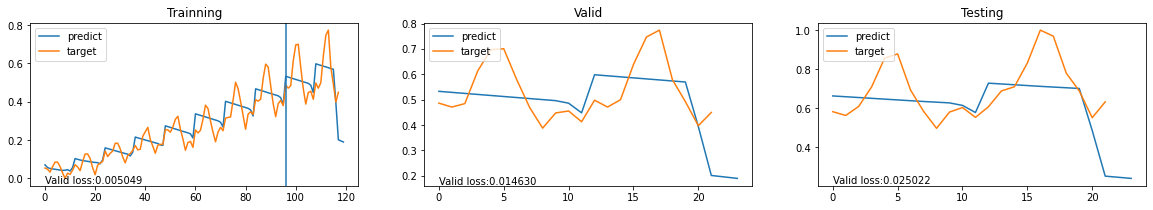

Epoch [36/10000] Saving model with train loss 0.005111, valid loss 0.014630...


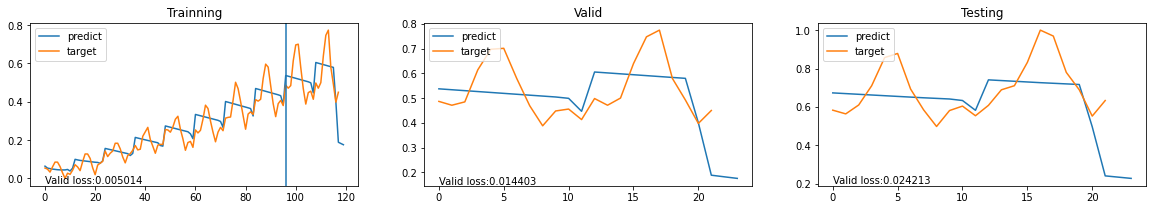

Epoch [40/10000] Saving model with train loss 0.003779, valid loss 0.014403...


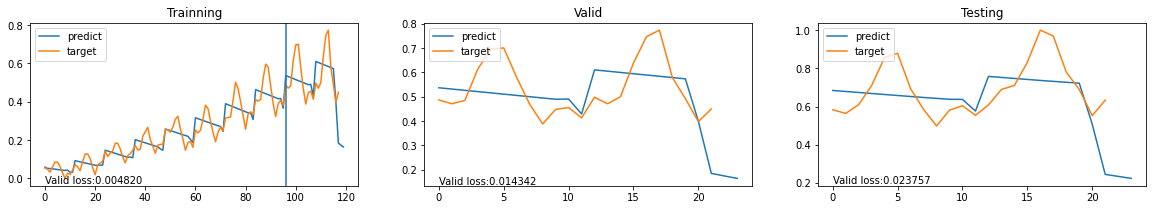

Epoch [56/10000] Saving model with train loss 0.003690, valid loss 0.014342...


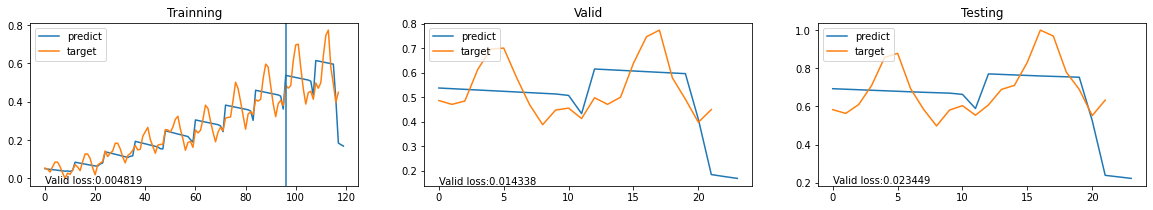

Epoch [65/10000] Saving model with train loss 0.003649, valid loss 0.014338...


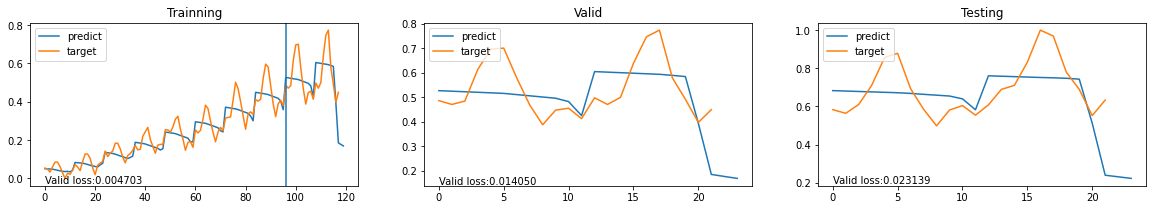

Epoch [74/10000] Saving model with train loss 0.004304, valid loss 0.014050...


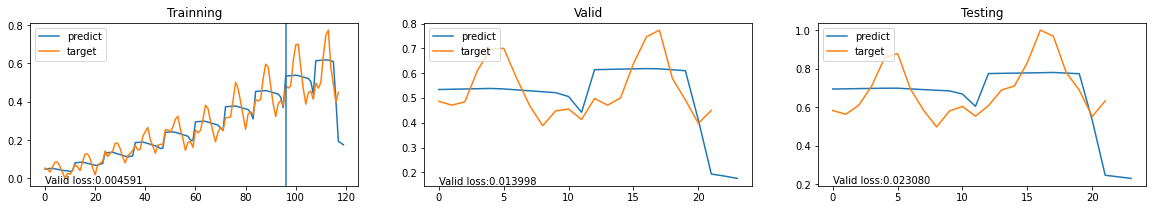

Epoch [76/10000] Saving model with train loss 0.003229, valid loss 0.013998...


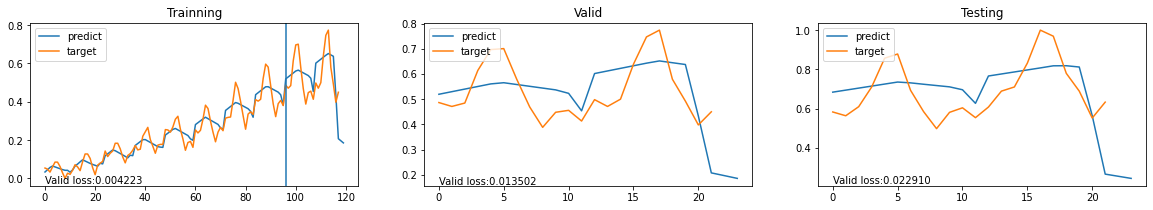

Epoch [83/10000] Saving model with train loss 0.003773, valid loss 0.013502...


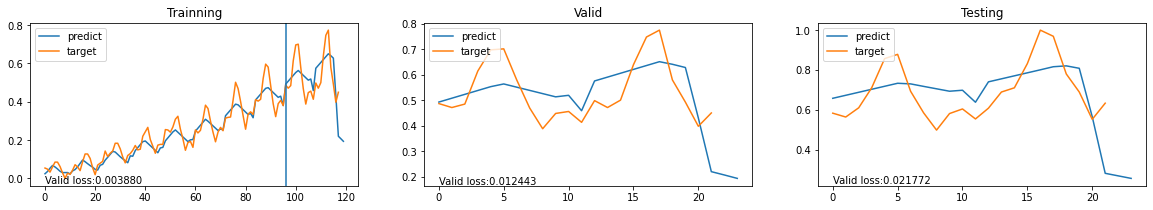

Epoch [87/10000] Saving model with train loss 0.002673, valid loss 0.012443...


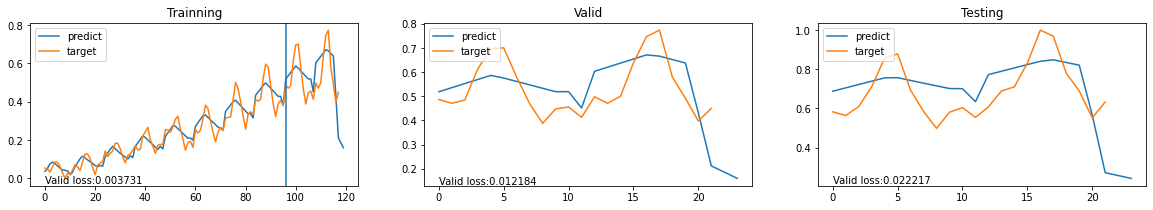

Epoch [88/10000] Saving model with train loss 0.002809, valid loss 0.012184...


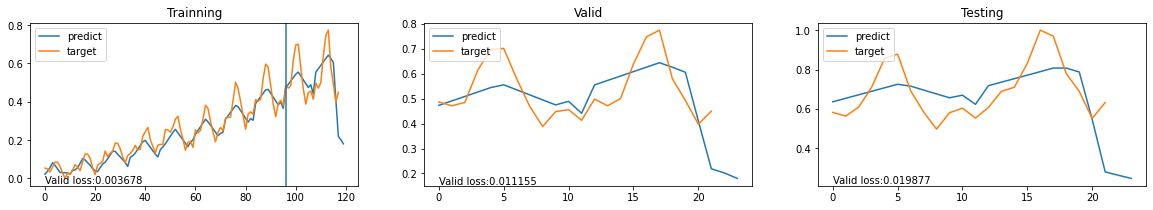

Epoch [92/10000] Saving model with train loss 0.002639, valid loss 0.011155...


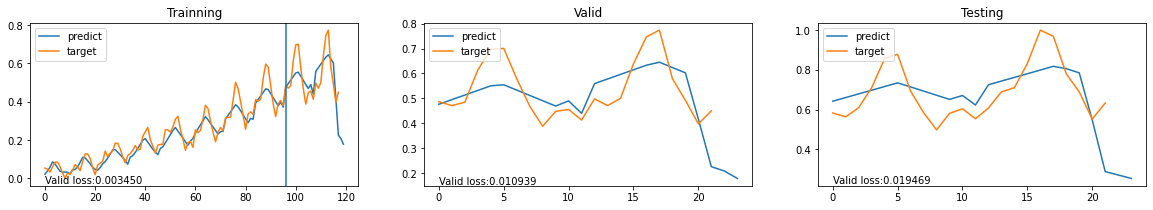

Epoch [93/10000] Saving model with train loss 0.002998, valid loss 0.010939...


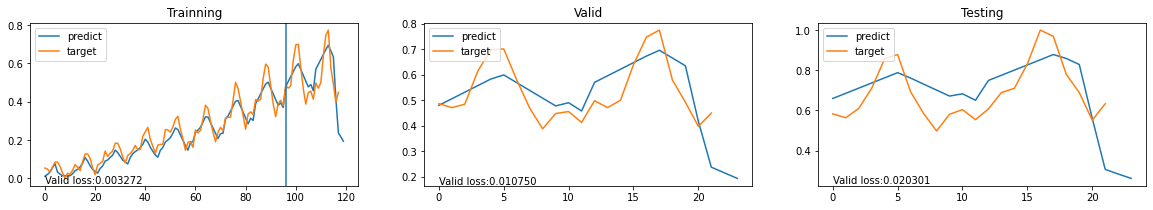

Epoch [103/10000] Saving model with train loss 0.002378, valid loss 0.010750...


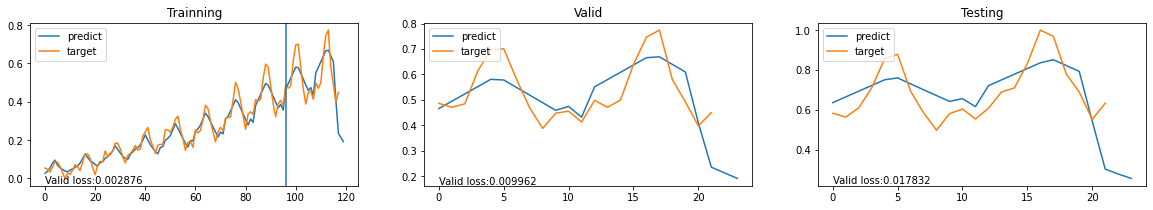

Epoch [104/10000] Saving model with train loss 0.002455, valid loss 0.009962...


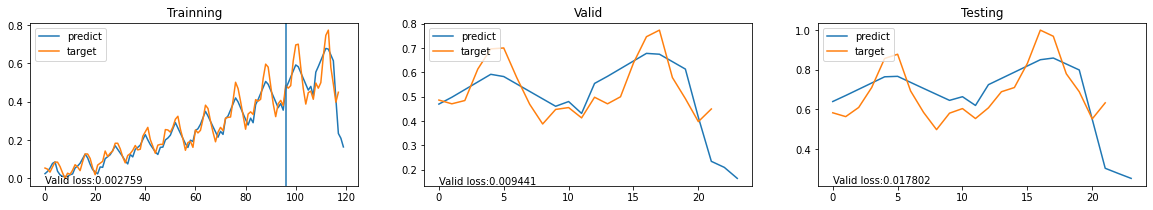

Epoch [105/10000] Saving model with train loss 0.001906, valid loss 0.009441...


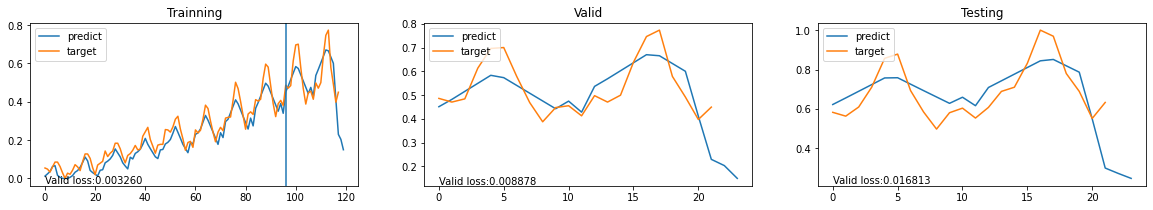

Epoch [107/10000] Saving model with train loss 0.001995, valid loss 0.008878...


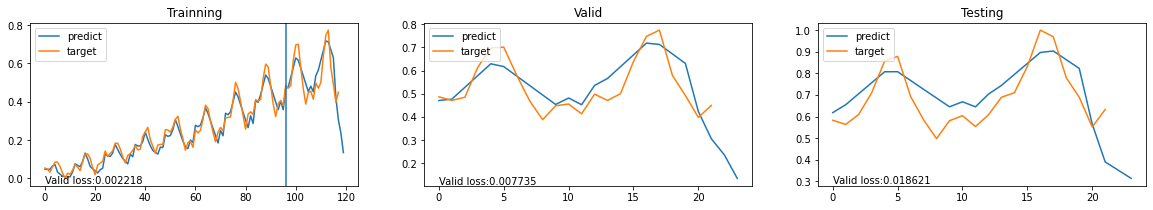

Epoch [121/10000] Saving model with train loss 0.001582, valid loss 0.007735...


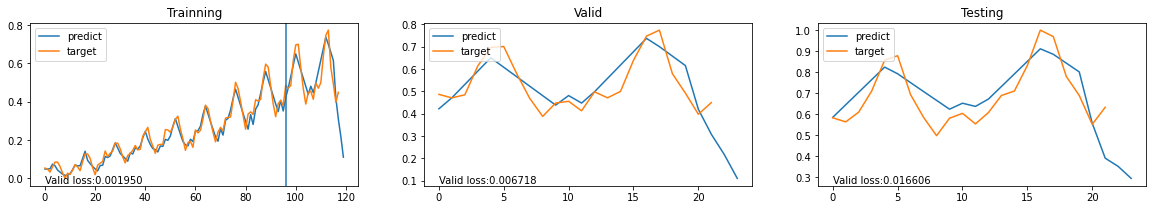

Epoch [125/10000] Saving model with train loss 0.001775, valid loss 0.006718...


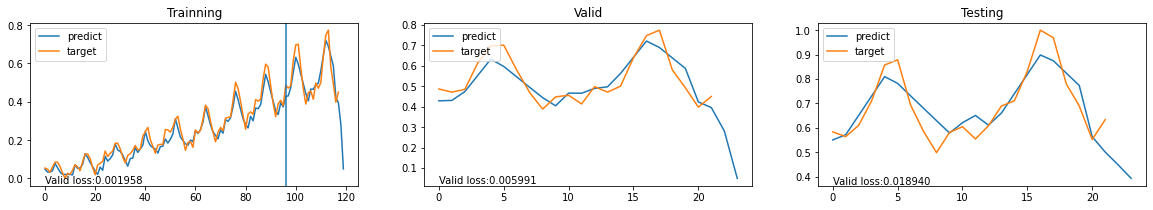

Epoch [195/10000] Saving model with train loss 0.001778, valid loss 0.005991...


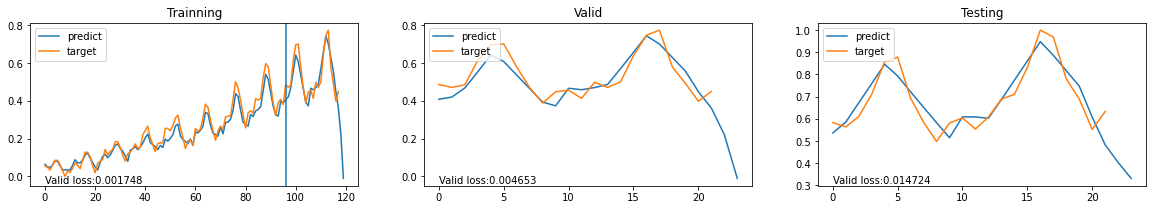

Epoch [351/10000] Saving model with train loss 0.001007, valid loss 0.004653...


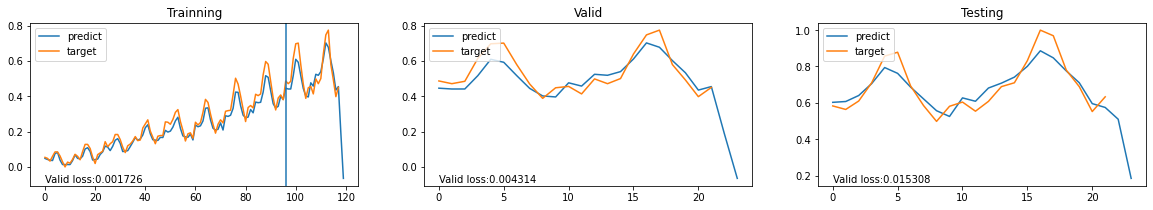

Epoch [853/10000] Saving model with train loss 0.000574, valid loss 0.004314...


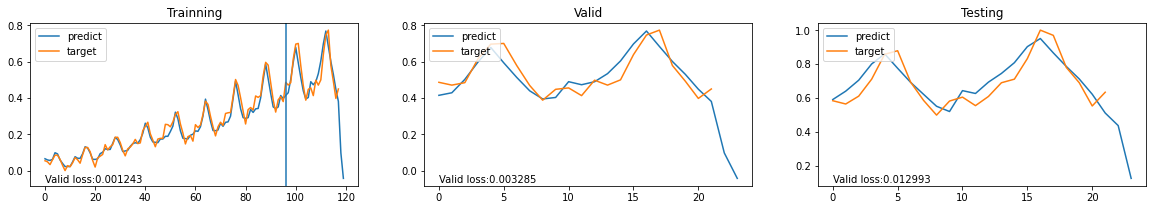

Epoch [880/10000] Saving model with train loss 0.001266, valid loss 0.003285...


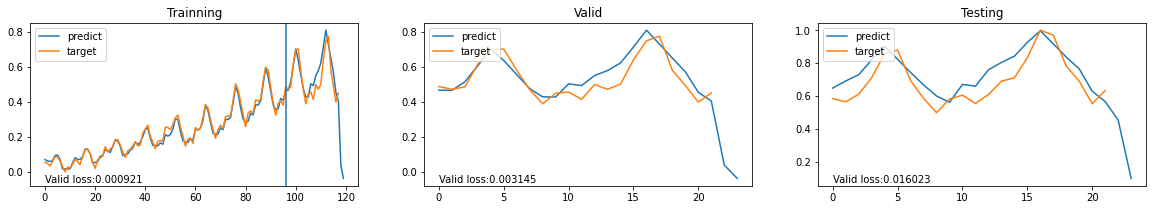

Epoch [1074/10000] Saving model with train loss 0.000536, valid loss 0.003145...

Model is not improving, so we halt the training session.


In [585]:
def trainer(train_loader, valid_loader, model, config, device):

    # 这里用了随机梯度下降，想改成Adam。但还没改。
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 
    
    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    
    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []
        for x, y in train_loader:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
        mean_train_loss = sum(loss_record)/len(loss_record)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                #pred, _ = model(x, h_state)
                pred = model(x)
                loss = criterion(pred, y)
            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        
        #print(f'Epoch [{epoch+1}/{n_epochs}]','train_loss {:.6f}, valid_loss {:.6f}..., best_loss {:.6f}'.format(mean_train_loss, mean_valid_loss, best_loss))
        #print(mean_train_loss,mean_valid_loss)
#         print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        #writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            #draw(x_train.shape[1])
            #print(f'Epoch [{epoch+1}/{n_epochs}]','Saving model with train loss {:.6f}, valid loss {:.6f}...'.format(mean_train_loss,best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')

model = My_Model(x_train.shape[1]).to(device) # put your model and data on the same computation device.
hidden = trainer(train_loader, valid_loader, model, config, device)

In [587]:
model

My_Model(
  (layer1): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [586]:
# %reload_ext tensorboard
# %tensorboard --logdir=./runs/

In [124]:
import matplotlib.pyplot as plt
model = LSTM(x_train.shape[1], config['window_size']).to(device)
model.load_state_dict(torch.load('./models/model0.ckpt'))

# 可视化结果。
def draw(f_cnt, model,TrainingSet = True,ValidSet = True, TestingSet = True):
    data = prep_data('./flights.csv')
    end = data.shape[1]
    train_data, test_data = train_valid_split(data, config['test_ratio'], config['seed'])
    train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])
    x_train, x_valid, x_test, y_train, y_valid, y_test = select_feat(train_data, valid_data, test_data, config['select_all'])
    
    a = x_valid.copy()
    b = y_valid.copy()
    x_train = np.vstack([x_train,a])
    y_train = np.hstack([y_train,b])
    window_size = config['window_size']
    train_dataset,valid_dataset, test_dataset = LSTMDataset(x_train,config['window_size'], y_train), \
                                  LSTMDataset(x_valid,config['window_size'], y_valid),\
                                  LSTMDataset(x_test,config['window_size'], y_test)
    # Pytorch data loader loads pytorch dataset into batches.
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)
    valid_set_size = int(config['valid_ratio'] * len(train_dataset) // config['batch_size'] * config['batch_size']) 
    train_data_length = len(train_dataset) - valid_set_size
    plt.figure(figsize=(20,3))
    
    down = 0.025
    if TrainingSet == True:
        # 绘制训练集
        plt.subplot(1,3,1)
        cnt = 0
        for i in train_loader:
            cnt = cnt + 1
        #print(cnt)
        preds,loss = predict(train_loader, model, device)
        preds = preds.reshape(-1)
        y = y_train[window_size-1:]
        plt.plot(preds,label='predict')
        plt.plot(y,label='target')
        minn = min(preds.min(),y.min())
        plt.text(0,minn-down,'Valid loss:{:.6f}'.format(loss))
        plt.axvline(train_data_length)
        plt.legend(loc='upper left')
        plt.title("Trainning") # 图形标题
        #print('Train+Valid loss:{:.6f}'.format(loss))
    
    if ValidSet == True:
        plt.subplot(1,3,2)
        cnt = 0
        for i in valid_loader:
            cnt = cnt + 1
        #print(cnt)
        preds,loss = predict(valid_loader, model, device)
        y = valid_data[window_size-1:,end-1:end].flatten()
        minn = min(preds.min(),y.min())
        plt.text(0,minn - down,'Valid loss:{:.6f}'.format(loss))
        plt.plot(preds,label='predict')
        plt.plot(y,label='target')
        plt.legend(loc='upper left')
        plt.title("Valid") # 图形标题
        #print('Valid loss:{:.6f}'.format(loss))

    if TestingSet == True:
        # 绘制测试集
        plt.subplot(1,3,3)
        preds, loss = predict(test_loader, model, device)
        y = test_data[window_size-1:,end-1:end].flatten()
        minn = min(preds.min(),y.min())
        plt.text(0,minn - down,'Valid loss:{:.6f}'.format(loss))
        plt.plot(preds,label='predict')
        plt.plot(y,label='target')
        plt.legend(loc='upper left')
        plt.title("Testing") # 图形标题
        #print('Testing loss:{:.6f}'.format(loss))
        pass
    plt.show()
draw(x_train.shape[1],ValidSet=True)

RuntimeError: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "rnn.weight_ih_l0", "rnn.weight_hh_l0", "rnn.bias_ih_l0", "rnn.bias_hh_l0", "rnn.weight_ih_l1", "rnn.weight_hh_l1", "rnn.bias_ih_l1", "rnn.bias_hh_l1", "reg.weight", "reg.bias". 
	Unexpected key(s) in state_dict: "layer1.0.weight", "layer1.0.bias", "layer1.2.weight", "layer1.2.bias", "layer1.4.weight", "layer1.4.bias". 